In [1]:
import numpy as np
import h5py

fn = "image1-competition.hdf5"

with h5py.File(fn, "r") as f:
    data = np.array(f["data"])
    wns = np.array(f["wns"])
    tissue_mask = np.array(f["tissue_mask"])
    classes = np.array(f["classes"])

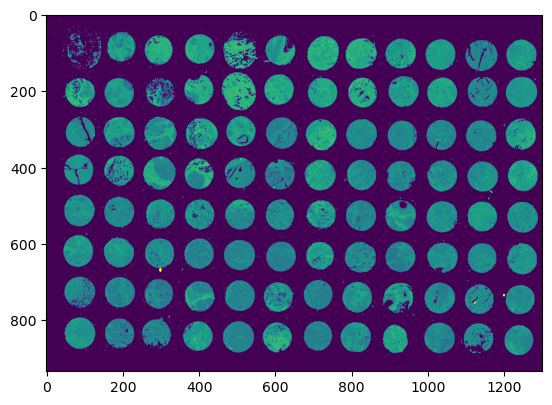

In [2]:
# display the whole image
import matplotlib.pyplot as plt

def nearest_ind(a, v):
    return np.abs(a - v).argmin()

im = data[:, :, nearest_ind(wns, 1560)]
plot = plt.imshow(im, vmin=0, vmax=1)

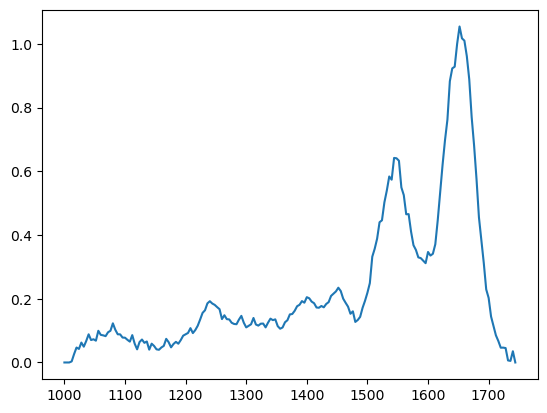

In [3]:
# a single "pixel" is a spectrum
plt.plot(wns, data[110, 220])
plt.show()

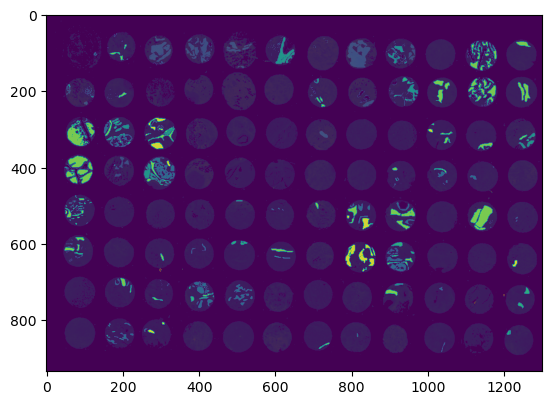

In [4]:
# the classes
plt.imshow(data[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)
plt.imshow(classes[:, :], alpha=0.8)

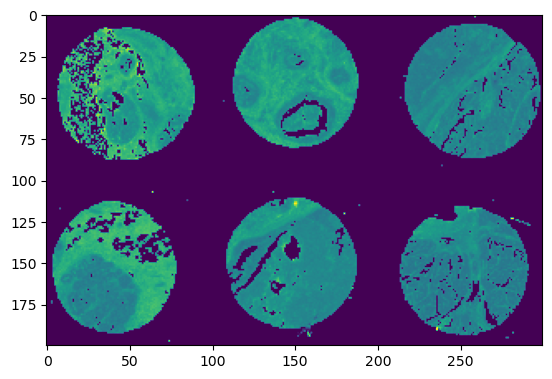

In [5]:
data_predict = data[265:465,360:660]
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [6]:
annotated_sel = classes != -1
X = data[annotated_sel]
y = classes[annotated_sel]

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

lr = LogisticRegression(max_iter=10000, C=0.001)
lr.fit(X, y)

LogisticRegression(C=0.001, max_iter=10000)

In [7]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


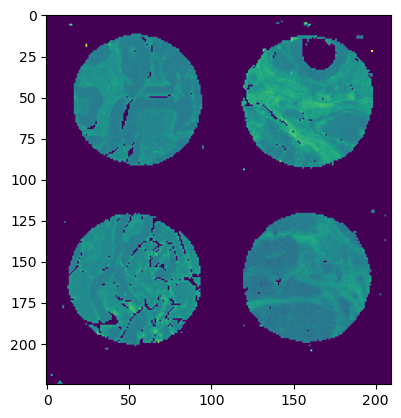

In [8]:
data_val = data[475:700,770:980]
plt.imshow(data_val[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

In [9]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self, input_features = 187 ,num_classes = 3):
        super(CNN, self).__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv1d(input_features, input_features, 15),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.Conv1d(input_features, input_features, 5),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.Conv1d(input_features, input_features, 3),
            nn.ReLU(),
            nn.BatchNorm1d(input_features),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(83, num_classes)


    def forward(self, x):
        x = self.conv_layer1(x)
        x = x.view(x.size(0), -1) 
        print(x.shape)
        return self.fc(x)

In [59]:
import torch.nn as nn

n1 = 75
n2 = 15
n3 = 15

class MLP(nn.Module):
    def __init__(self, input_features=187, num_classes=3,n1=n1, n2 = n2, n3 = n3):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_features,n1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(n1,n2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(n2,num_classes),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            # nn.Linear(n3, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
from sklearn.preprocessing import StandardScaler
import torch
import numpy as np
from tqdm import tqdm


validation = True # Set to False to train on all annotated data without validation
# Create masks
annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
annotated_sel_val[475:700,770:980] = 1

if validation:
    annotated_train_mask = annotated_sel & ~annotated_sel_val
    annotated_val_mask   = annotated_sel &  annotated_sel_val
else:
    annotated_train_mask = annotated_sel
    annotated_val_mask   = None  # Not used

# Split data
X_train = data[annotated_train_mask]
y_train = classes[annotated_train_mask]

if validation:
    X_val = data[annotated_val_mask]
    y_val = classes[annotated_val_mask]
    val_rows, val_cols = np.where(annotated_val_mask)
    X_val = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_val, val_rows, val_cols)])
    # Get (row, column) indices of training points
train_rows, train_cols = np.where(annotated_train_mask)

# Now add the position to the features

X_train = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_train, train_rows, train_cols)])


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if validation:
    X_val = scaler.transform(X_val)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
#X_train = X_train.unsqueeze(1) # For CNNS
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
if validation:
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    #X_val = X_val.unsqueeze(1)# For CNNS
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)


min_val_loss = 0.45
for lam in tqdm([0, 0.00001, 0.0001, 0.001, 0.01]):
    for lr in [0.001, 0.0005, 0.0002, 0.0001]:
        print(f"lr ={lr}")
        for n1 in range(15,151, 10):
            print(f"n1 = {n1}")
            for n2 in range(5, 51, 10):
                print(f"n2 = {n2}")
                np.random.seed(2)
                torch.manual_seed(2)

                # Model, loss, optimizer
                model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy())), n1=n1, n2=n2).to(device)
                #model = CNN(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=lam) # for mlp lr = 0.0001

                # Training loop
                epochs = 15000

                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    outputs = model(X_train)
                    loss = loss_fn(outputs, y_train)
                    loss.backward()
                    optimizer.step()

                    train_loss = loss.item()

                    # Validation
                    if validation:
                        model.eval()
                        with torch.inference_mode():
                            val_outputs = model(X_val)
                            val_loss = loss_fn(val_outputs, y_val).item()
                            predictions = torch.argmax(val_outputs, dim=1)
                            val_acc = (predictions == y_val).sum().item() / y_val.size(0)
                        if val_loss < min_val_loss:
                            min_val_loss = val_loss
                            print(val_loss, epoch, n1, n2, lr, lam)
                        #print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
                    else:
                        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")

Using device: cuda


  0%|          | 0/5 [00:00<?, ?it/s]

lr =0.001
n1 = 15
n2 = 5


In [94]:
n1 = 45
n2 = 15
lr = 0.0001

validation = False # Set to False to train on all annotated data without validation
# Create masks
annotated_sel_val = np.zeros_like(annotated_sel, dtype=bool)
annotated_sel_val[475:700,770:980] = 1

if validation:
    annotated_train_mask = annotated_sel & ~annotated_sel_val
    annotated_val_mask   = annotated_sel &  annotated_sel_val
else:
    annotated_train_mask = annotated_sel
    annotated_val_mask   = None  # Not used

# Split data
X_train = data[annotated_train_mask]
y_train = classes[annotated_train_mask]

if validation:
    X_val = data[annotated_val_mask]
    y_val = classes[annotated_val_mask]
    val_rows, val_cols = np.where(annotated_val_mask)
    X_val = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_val, val_rows, val_cols)])
    # Get (row, column) indices of training points
train_rows, train_cols = np.where(annotated_train_mask)

# Now add the position to the features

X_train = np.array([np.concatenate([np.array([train_row, train_col]), x]) for x, train_row, train_col in zip(X_train, train_rows, train_cols)])


# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
if validation:
    X_val = scaler.transform(X_val)

# Convert to tensors and move to device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
#X_train = X_train.unsqueeze(1) # For CNNS
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
if validation:
    X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
    #X_val = X_val.unsqueeze(1)# For CNNS
    y_val = torch.tensor(y_val, dtype=torch.long).to(device)

np.random.seed(2)
torch.manual_seed(2)

# Model, loss, optimizer
model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy())), n1=n1, n2=n2).to(device)
#model = CNN(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00) # for mlp lr = 0.0001

# Training loop
epochs = 3500

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = loss_fn(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_loss = loss.item()

    # Validation
    if validation:
        model.eval()
        with torch.inference_mode():
            val_outputs = model(X_val)
            val_loss = loss_fn(val_outputs, y_val).item()
            predictions = torch.argmax(val_outputs, dim=1)
            val_acc = (predictions == y_val).sum().item() / y_val.size(0)
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            print(val_loss, epoch, n1, n2, lr)
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")

Using device: cuda
Epoch 1/3500: Train loss=1.7811
Epoch 2/3500: Train loss=1.7775
Epoch 3/3500: Train loss=1.7749
Epoch 4/3500: Train loss=1.7724
Epoch 5/3500: Train loss=1.7692
Epoch 6/3500: Train loss=1.7660
Epoch 7/3500: Train loss=1.7629
Epoch 8/3500: Train loss=1.7603
Epoch 9/3500: Train loss=1.7574
Epoch 10/3500: Train loss=1.7547
Epoch 11/3500: Train loss=1.7516
Epoch 12/3500: Train loss=1.7499
Epoch 13/3500: Train loss=1.7462
Epoch 14/3500: Train loss=1.7434
Epoch 15/3500: Train loss=1.7408
Epoch 16/3500: Train loss=1.7375
Epoch 17/3500: Train loss=1.7345
Epoch 18/3500: Train loss=1.7327
Epoch 19/3500: Train loss=1.7298
Epoch 20/3500: Train loss=1.7270
Epoch 21/3500: Train loss=1.7242
Epoch 22/3500: Train loss=1.7223
Epoch 23/3500: Train loss=1.7180
Epoch 24/3500: Train loss=1.7149
Epoch 25/3500: Train loss=1.7133
Epoch 26/3500: Train loss=1.7097
Epoch 27/3500: Train loss=1.7073
Epoch 28/3500: Train loss=1.7049
Epoch 29/3500: Train loss=1.7008
Epoch 30/3500: Train loss=1.6990


In [ ]:
# Option with batches, for larger models

from torch.utils.data import DataLoader, TensorDataset

np.random.seed(42)
torch.manual_seed(42)

validation = True # Set to False to train on all annotated data without validation
batch_size = 1000

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

if validation:
    val_dataset = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Define model
model = MLP(X_train.shape[1], len(np.unique(y_train.cpu().numpy()))).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Training loop
epochs = 150

for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)

    train_loss /= len(train_loader.dataset)

    # Validation
    if validation:
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.inference_mode():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = loss_fn(outputs, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                predictions = torch.argmax(outputs, dim=1)
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}, Val loss={val_loss:.4f}, Val acc={val_acc:.4f}")
    else:
        print(f"Epoch {epoch+1}/{epochs}: Train loss={train_loss:.4f}")


In [95]:
data_predict = data[265:465,360:660]

# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])

# Create row and column indices
rows = np.arange(265, 465)  # rows 265 to 464
cols = np.arange(360, 660)  # cols 360 to 659

# Build full grid of (row, col) positions
grid_rows, grid_cols = np.meshgrid(rows, cols, indexing='ij')
grid_rows = grid_rows.flatten()
grid_cols = grid_cols.flatten()

# Add positions to the spectra
lin_data_predict = np.array([
    np.concatenate([np.array([r, c]), spectrum]) 
    for spectrum, r, c in zip(lin_data_predict, grid_rows, grid_cols)
])

lin_data_predict = scaler.transform(lin_data_predict)

tissue_mask_predict = tissue_mask[265:465,360:660]

lin_data_predict_tensor = torch.tensor(lin_data_predict, dtype=torch.float32).to(device) 

# Predict
model.eval()
with torch.inference_mode():
    pred_logits = model(lin_data_predict_tensor)
    pred_probs = torch.softmax(pred_logits, dim=1) 
    pred_labels = torch.argmax(pred_probs, dim=1)


# Reshape the predicted probabilities to match the data dimensions
pred_probs_reshaped = pred_probs.cpu().numpy().reshape(data_predict.shape[:2] + lin_pred.shape[-1:])
pred_labels_reshaped = pred_labels.cpu().numpy().reshape(data_predict.shape[:2])

background_pred = np.array([0, 1, 0, 0, 0, 0], dtype=pred_probs_reshaped.dtype)

mask_region = ~tissue_mask_predict.astype(bool)
pred_probs_reshaped[mask_region] = background_pred

# Save the probabilities
np.save("basic_prediction_probs.npy", pred_probs_reshaped.astype(np.float32))


In [ ]:
# take spectra for prediction in a linearized sequence
lin_data_predict = data_predict.reshape(-1, data_predict.shape[-1])
lin_data_predict = scaler.transform(lin_data_predict)

lin_pred = lr.predict_proba(lin_data_predict)
pred = lin_pred.reshape(data_predict.shape[:2] + lin_pred.shape[-1:])

with open("multilogreg.npy", "wb") as f:
    np.save(f, pred.astype(np.float32))


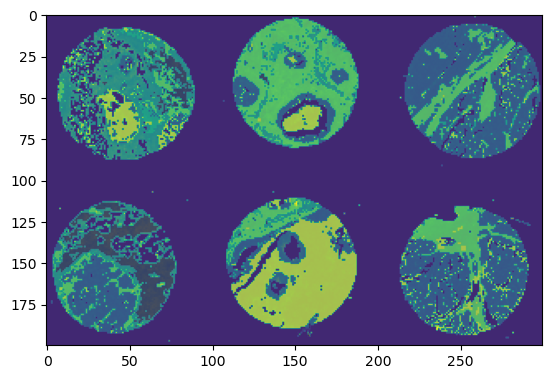

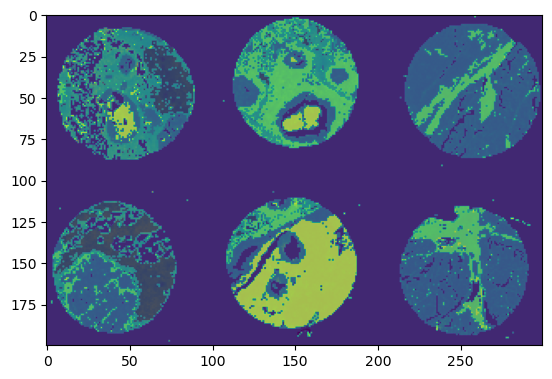

In [ ]:
# Get predicted class labels
pred_labels = np.argmax(pred, axis=-1)

# Show the background reflectance map at ~1560nm
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay predicted class labels
plt.imshow(pred_labels, alpha=0.6)
plt.show()

# Show a background image: a reflectance map at wavelength nearest to 1560
plt.imshow(data_predict[:, :, nearest_ind(wns, 1560)], vmin=0, vmax=1)

# Overlay the predicted labels (already reshaped)
plt.imshow(pred_labels_reshaped, alpha=0.6) 